# Capstone Project - Inferential Statistics
*Kimberly Kaufman*  
*August 15, 2019*
  
---

### Introduction

Previously, we cleaned and wrangled our volume and freight datasets and told a data story around the EDA we had done thus far.  At this point, we'll be applying inferential statistics in order to glean additional information around the dataset that we'll be working with.

For more details on this project, see the <a href="https://github.com/kaufkauf/Capstone-Project-Intermediate">GitHub repository</a>.

#### Data Import & Wrangling Review

As a review, below are the steps we took to wrangle the initial datasets into a single, inclusive Pandas data frame.

In [2]:
import pandas as pd
import numpy as np

# set working directory & read in files
wd = 'C:/Users/kkaufman/Documents/Data Sci/Intermediate/Freight model/'
vol1 = pd.read_csv(wd + 'FY19outboundv2 - Q1.csv', low_memory=False)
vol2 = pd.read_csv(wd + 'FY19outboundv2 - Q2.csv', low_memory=False)
vol3 = pd.read_csv(wd + 'FY19outboundv2 - Q3.csv', low_memory=False)
vol4 = pd.read_csv(wd + 'FY19outboundv2 - Q4.csv', low_memory=False)
vol = vol1.append([vol2,vol3,vol4])
missfts = pd.read_csv(wd + 'FY19missingfreight.csv', low_memory=False)
freight = pd.read_csv(wd + 'FY19freightcharges2.csv', low_memory=False) 

# new updates: fill in missing freight types
vol['SHIP_METHOD'] = vol['SHIP_METHOD'].str.strip()
vol = pd.merge(left=vol, right=missfts, how='left', left_on=['SHIP_METHOD'], right_on=['SHIP_METHOD'],copy=False)
vol['FREIGHT_TYPE'] = vol['FREIGHT_TYPE'].fillna(vol['FREIGHT TYPE'])
vol = vol.drop(columns=['STYLE CODE','FREIGHT TYPE'],axis=1)

# other data wrangling steps:
# remove trailing spaces from categoricals:
vol['SHIP_COUNTRY_NAME'] = vol['SHIP_COUNTRY_NAME'].str.title().str.strip().fillna('Unknown')
# cap/floor book weight outliers at 5th/95th percentiles
vol['BOOK_WEIGHT'] = np.where(vol['BOOK_WEIGHT'] < vol['BOOK_WEIGHT'].quantile(.05), vol['BOOK_WEIGHT'].quantile(.05), vol['BOOK_WEIGHT'])
vol['BOOK_WEIGHT'] = np.where(vol['BOOK_WEIGHT'] > vol['BOOK_WEIGHT'].quantile(.95), vol['BOOK_WEIGHT'].quantile(.95), vol['BOOK_WEIGHT'])

# pivot volume data based on invoice number & convert to dataframe
idxcols = ['CJDAT1','IHINDT','IHAEDT','INVOICENO','COLLECT_METHOD','CARRIER_CODE','PRIORITY_CODE','SHIP_METHOD','FREIGHT_TYPE','SHIP_COUNTRY_NAME','MARKET_OUTLET']
valcols = ['ISBN10','TOTAL_UNITS','TOTAL_PALLETS','TOTAL_CARTONS','TOTAL_LOOSE','BOOK_WEIGHT']
dfvol = pd.pivot_table(vol, index=idxcols, columns=['GLOBAL_BUSINESS'], values=valcols, 
                       aggfunc={('ISBN10') : len,
                                ('TOTAL_UNITS') : sum,
                                ('TOTAL_PALLETS') : sum,
                                ('TOTAL_CARTONS') : sum,
                                ('TOTAL_LOOSE') : sum,
                                ('BOOK_WEIGHT') : sum}, 
                                fill_value=0)
dfvol = pd.DataFrame(dfvol)
dfvol.reset_index(inplace=True)

# remove multilevel column index & replace with concatenated column names using list comprehension
cols = [str.strip(str.replace((key + ' ' + value),'ISBN10','TOTAL_LINES')) for key, value in dfvol.columns]
dfvol.columns = dfvol.columns.get_level_values(0)
dfvol.columns = cols

# add columns for carton weight & totals
dfvol['CARTON_WEIGHT Agency'] = dfvol['BOOK_WEIGHT Agency']*dfvol['TOTAL_UNITS Agency']
dfvol['CARTON_WEIGHT Education'] = dfvol['BOOK_WEIGHT Education']*dfvol['TOTAL_UNITS Education']
dfvol['CARTON_WEIGHT Reference'] = dfvol['BOOK_WEIGHT Reference']*dfvol['TOTAL_UNITS Reference']
dfvol['CARTON_WEIGHT Test Prep'] = dfvol['BOOK_WEIGHT Test Prep']*dfvol['TOTAL_UNITS Test Prep']
dfvol['CARTON_WEIGHT Trade'] = dfvol['BOOK_WEIGHT Trade']*dfvol['TOTAL_UNITS Trade']
dfvol['TOTAL CARTONS Total'] = dfvol['TOTAL_CARTONS Agency']+dfvol['TOTAL_CARTONS Education']+dfvol['TOTAL_CARTONS Reference']+dfvol['TOTAL_CARTONS Test Prep']+dfvol['TOTAL_CARTONS Trade']
dfvol['TOTAL LOOSE Total'] = dfvol['TOTAL_LOOSE Agency']+dfvol['TOTAL_LOOSE Education']+dfvol['TOTAL_LOOSE Reference']+dfvol['TOTAL_LOOSE Test Prep']+dfvol['TOTAL_LOOSE Trade']
dfvol['TOTAL PALLETS Total']= dfvol['TOTAL_PALLETS Agency']+dfvol['TOTAL_PALLETS Education']+dfvol['TOTAL_PALLETS Reference']+dfvol['TOTAL_PALLETS Test Prep']+dfvol['TOTAL_PALLETS Trade']
dfvol['TOTAL UNITS Total'] = dfvol['TOTAL_UNITS Agency']+dfvol['TOTAL_UNITS Education']+dfvol['TOTAL_UNITS Reference']+dfvol['TOTAL_UNITS Test Prep']+dfvol['TOTAL_UNITS Trade']
dfvol['CARTON_WEIGHT Total'] = dfvol['CARTON_WEIGHT Agency']+dfvol['CARTON_WEIGHT Education']+dfvol['CARTON_WEIGHT Reference']+dfvol['CARTON_WEIGHT Test Prep']+dfvol['CARTON_WEIGHT Trade']

# join vol data to freight data
dffreight = freight[['INVNUMBER','INTDATE','TOTALCHARGE']]
df1 = pd.merge(left=dfvol, right=dffreight, how='left', left_on=['INVOICENO','CJDAT1'], right_on=['INVNUMBER','INTDATE'],copy=False)
df1['TOTALCHARGE'] = df1['TOTALCHARGE'].fillna(0)
df1 = df1.drop(columns=['INVNUMBER','INTDATE'],axis=1)

# Convert dates to dates & add monthly fields
df1['IHAEDT'] = df1['IHAEDT']+19000000
df1['IHAEDT'] = pd.to_datetime(df1['IHAEDT'],format='%Y%m%d')
df1['SHIP_MONTH'] = df1['IHAEDT'].dt.to_period('M')

# Print resulting columns
df1.head()

,CJDAT1,IHINDT,IHAEDT,INVOICENO,COLLECT_METHOD,CARRIER_CODE,PRIORITY_CODE,SHIP_METHOD,FREIGHT_TYPE,SHIP_COUNTRY_NAME,...,CARTON_WEIGHT Reference,CARTON_WEIGHT Test Prep,CARTON_WEIGHT Trade,TOTAL CARTONS Total,TOTAL LOOSE Total,TOTAL PALLETS Total,TOTAL UNITS Total,CARTON_WEIGHT Total,TOTALCHARGE,SHIP_MONTH
0,0,1180911,2018-09-11,9477531,Y,UPSN,A3,UPS 2-Day Collect - Acct# Req.,Domestic Air Courier,United States,...,0.0,0.0,0.00,0,2,0,2,25.60,0.0,2018-09
1,1180202,1180202,2018-05-18,6302931,Y,INTN,IX,GP OCEAN FREIGHT COLLECT,Subsidiary Ship Methods,Singapore,...,0.0,0.0,336.00,0,20,0,20,336.00,0.0,2018-05
2,1180206,1180206,2018-05-18,6345851,Y,INTN,IX,GP OCEAN FREIGHT COLLECT,Subsidiary Ship Methods,Singapore,...,0.0,0.0,216.00,0,10,0,10,216.00,0.0,2018-05
3,1180206,1180206,2018-05-18,6348364,Y,INTN,IX,GP OCEAN FREIGHT COLLECT,Subsidiary Ship Methods,Singapore,...,0.0,688.0,0.00,10,0,0,10,688.00,0.0,2018-05
4,1180206,1180206,2018-05-18,6348365,Y,INTN,IX,GP OCEAN FREIGHT COLLECT,Subsidiary Ship Methods,Singapore,...,0.0,0.0,1500.24,0,5,0,19,1500.24,0.0,2018-05


### Is the distribution of our freight charges normal?

Not necessarily.  Let's take a look at our histograms below.

At first, using a histogram of all of our freight charges, our data looks possibly normal, but the curve is very narrow due to the high outliers we have that are stretching out our x-axis.  If we plot a second histogram that ranges from 0 to our 95th percentile (approximately 34), we can see a bit more detail.  In particular, our distribution is not exactly normal--it has a bit of a right skew.  This is likely due to some of the outliers that we have on the higher side.

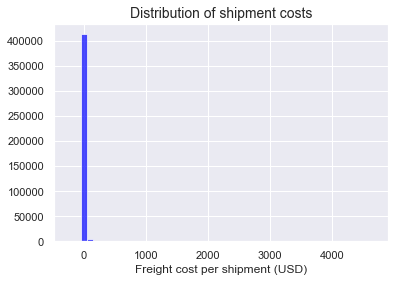

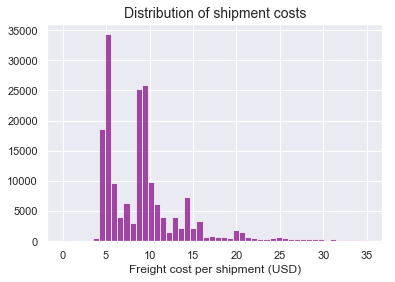

0.05     4.8875
0.10     4.8990
0.20     5.1750
0.30     5.8305
0.40     8.4640
0.50     9.0390
0.60     9.6830
0.70    10.1430
0.80    13.4895
0.90    19.7225
0.95    33.9503
Name: TOTALCHARGE, dtype: float64

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

plt.hist(x=df1['TOTALCHARGE'],bins=50,color='blue',alpha=0.7)
plt.xlabel('Freight cost per shipment (USD)')
plt.title('Distribution of shipment costs',fontsize=14)
plt.show()

df2 = df1[df1['TOTALCHARGE'] > 0]
plt.hist(x=df2['TOTALCHARGE'],bins=50,range=(0,35),color='purple',alpha=0.7)
plt.xlabel('Freight cost per shipment (USD)')
plt.title('Distribution of shipment costs',fontsize=14)
plt.show()
df2['TOTALCHARGE'].describe()
df2['TOTALCHARGE'].quantile([.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95])

### Hypothesis testing with a non-normal distribution

Since we're working with a skewed distribution, we're limited to either non-parametric testing methods, or parametric testing methods that can be used given a large enough distribution size (per the CLT, > 30).

For the purposes of our preliminary statistical analysis, we can perform a one-sample z-test on the mean cost per unit.  We can take the average cost currently being used for some of our FP&A planning models (currently about 1 USD per unit) and do a hypothesis test to see if, given a one year sample, that 1 USD per unit unit is actually the mean.  Therefore, given a mean (x) cost per unit for this sample:  
  
Ho: x - 1 = 0  
H1: x - 1 =/= 0  

In [25]:
df1['CHARGE PER UNIT'] = np.where(df1['TOTAL UNITS Total'] == 0, 0, df1['TOTALCHARGE']/df1['TOTAL UNITS Total'])  
#print(df1['TOTAL UNITS Total'].describe())

# One Sample z-test & p-value (two tailed test)
z = (np.mean(df1['CHARGE PER UNIT'])-1)/(np.std(df1['CHARGE PER UNIT'])/np.sqrt(130))
print("z = ",z)

z =  4.452441821071005


This yields a z-score of 4.45. If we use a confidence interval of 95% for our mean, we would expect our z-score to be between -1.96 and 1.96. Given our z-score outside this range (4.45 > 1.96), we can reject the null hypothesis and conclude that the mean cost per unit of our sample is not equal to 1 USD per unit.